In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt


In [3]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

In [4]:
train= pd.read_csv('C:/Users/bioni/PycharmProjects/quora/train.csv')

In [5]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


Percent of insincere entries 6.187 %


,qid,question_text,target
22,0000e91571b60c2fb487,Has the United States become the largest dicta...,1
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents...,1
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory ...,1
114,00052793eaa287aff1e1,I am gay boy and I love my cousin (boy). He is...,1
115,000537213b01fd77b58a,Which races have the smallest penis?,1


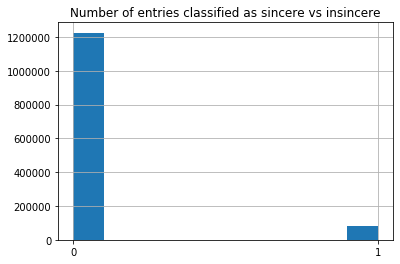

In [6]:
fig,ax = plt.subplots(1,1)
train.hist(column = 'target', ax = ax)
ax.set_title('Number of entries classified as sincere vs insincere')
ax.set_xticks([0,1])
print('Percent of insincere entries %.3f %%'%(100*(sum(train['target'])/len(train))))

train[train['target']==1].head()

In [7]:
embeddings_index = {}
f = open('C:/Users/bioni/PycharmProjects/quora/glove.840B.300d/glove.840B.300d.txt',encoding="utf-8")
for line in f:
    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vectors representing the embedding for the word
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded')

GloVe data loaded


In [8]:
import re

## Iterate over the data to preprocess by removing stopwords
lines_without_stopwords=[] 
for line in train['question_text'].values: 
    line = line.lower()
    line_by_words = re.findall(r'(?:\w+)', line, flags = re.UNICODE) # remove punctuation and split
    new_line=[]
    for word in line_by_words:
        if word not in stop:
            new_line.append(word)
    lines_without_stopwords.append(new_line)
texts = lines_without_stopwords

print(texts[0:5])

[['quebec', 'nationalists', 'see', 'province', 'nation', '1960s'], ['adopted', 'dog', 'would', 'encourage', 'people', 'adopt', 'shop'], ['velocity', 'affect', 'time', 'velocity', 'affect', 'space', 'geometry'], ['otto', 'von', 'guericke', 'used', 'magdeburg', 'hemispheres'], ['convert', 'montra', 'helicon', 'mountain', 'bike', 'changing', 'tyres']]


In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

MAX_NUM_WORDS = 1000
MAX_SEQUENCE_LENGTH = 100
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(train['target']))
print(data.shape)
print(labels.shape)

Using TensorFlow backend.


Found 195238 unique tokens.
(1306122, 100)
(1306122, 2)


In [10]:
from keras.layers import Embedding
from keras.initializers import Constant

## EMBEDDING_DIM =  ## seems to need to match the embeddings_index dimension
EMBEDDING_DIM = embeddings_index.get('a').shape[0]
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word) ## This references the loaded embeddings dictionary
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

(1001, 300)


Text(0.5, 1.0, 'example vectors')

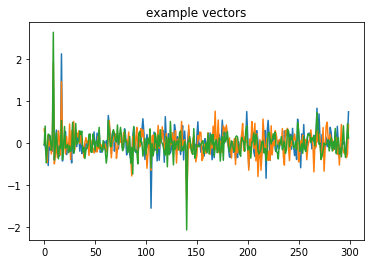

In [11]:
print(embedding_matrix.shape)
plt.plot(embedding_matrix[16])
plt.plot(embedding_matrix[37])
plt.plot(embedding_matrix[18])
plt.title('example vectors')

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation

model = Sequential()
model.add(Embedding(num_words, 300, input_length=100, weights= [embedding_matrix], trainable=False))

model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
print(labels.shape)
model.fit(data, np.array(labels), validation_split=0.1, epochs = 4)

(1306122, 2)

Train on 1175509 samples, validate on 130613 samples
Epoch 1/1
1175509/1175509 [==============================] - 1985s 2ms/step - loss: 0.1558 - accuracy: 0.9454 - val_loss: 0.1538 - val_accuracy: 0.9460


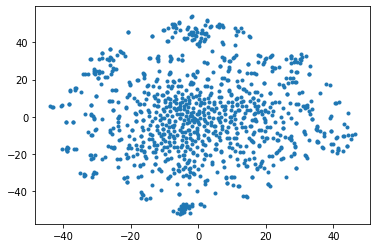

In [14]:
from sklearn.manifold import TSNE
## Get weights
embds = model.layers[0].get_weights()[0]
## Plotting function
## Visualize words in two dimensions 
tsne_embds = TSNE(n_components=2).fit_transform(embds)

plt.plot(tsne_embds[:,0],tsne_embds[:,1],'.')

In [15]:
test= pd.read_csv('C:/Users/bioni/PycharmProjects/quora/test.csv')

In [16]:
test.head()


,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


In [17]:
import re
## Iterate over the data to preprocess by removing stopwords
lines_without_stopwords=[]  
for line in test['question_text'].values: 
    line = line.lower()
    line_by_words = re.findall(r'(?:\w+)', line, flags = re.UNICODE) # remove punctuation ans split
    new_line=[]
    for word in line_by_words:
        if word not in stop:
            new_line.append(word)
    lines_without_stopwords.append(new_line)
texts = lines_without_stopwords
print(texts[0:5])


[['many', 'women', 'become', 'rude', 'arrogant', 'get', 'little', 'bit', 'wealth', 'power'], ['apply', 'rv', 'college', 'engineering', 'bms', 'college', 'engineering', 'wait', 'comedk', 'result', 'supposed', 'apply', 'result'], ['really', 'like', 'nurse', 'practitioner'], ['entrepreneurs'], ['education', 'really', 'making', 'good', 'people', 'nowadays']]


In [18]:
MAX_NUM_WORDS = 1000
MAX_SEQUENCE_LENGTH = 100
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


Found 101889 unique tokens.


In [19]:
pred=model.predict(data, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)

In [20]:
pred = np.round(pred)
pred = pred.astype(int)
pred=np.delete(pred,1,1)

In [21]:
pred

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [23]:
df2 = pd.DataFrame(data=pred)
df2.columns =['pred']
df2

,pred
0,1
1,0
2,1
3,1
4,1
...,...
375801,1
375802,1
375803,1
375804,1


In [26]:
result.to_csv("submission.csv", index=False)

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          300300    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 64)            96064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 462,566
Trainable params: 162,266
Non-trainable params: 300,300
__________________________________________

In [ ]:
model.save('my_model.h5')

In [ ]:
from keras.models import load_model
model = load_model('C:/Users/bioni/PycharmProjects/quora/my_model.h5')
print('Model Loaded')